In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import os
from pathlib import Path

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

data_folder = Path("../data")
dataset_location = data_folder / "hcvdat0.csv"

# Necessary for notebook to see src
import sys
sys.path.append('..')

from src.visualization import plot_corelation_matrix, plot_continuous_columns

Device: cuda


# Load Dataset


In [2]:
original_dataset = pd.read_csv(dataset_location)
dataset = original_dataset.copy(deep=True)

dataset.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
dataset.head(10)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
5,0=Blood Donor,32,m,41.6,43.3,18.5,19.7,12.3,9.92,6.05,111.0,91.0,74.0
6,0=Blood Donor,32,m,46.3,41.3,17.5,17.8,8.5,7.01,4.79,70.0,16.9,74.5
7,0=Blood Donor,32,m,42.2,41.9,35.8,31.1,16.1,5.82,4.60,109.0,21.5,67.1
8,0=Blood Donor,32,m,50.9,65.5,23.2,21.2,6.9,8.69,4.10,83.0,13.7,71.3
9,0=Blood Donor,32,m,42.4,86.3,20.3,20.0,35.2,5.46,4.45,81.0,15.9,69.9


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  615 non-null    object 
 1   Age       615 non-null    int64  
 2   Sex       615 non-null    object 
 3   ALB       614 non-null    float64
 4   ALP       597 non-null    float64
 5   ALT       614 non-null    float64
 6   AST       615 non-null    float64
 7   BIL       615 non-null    float64
 8   CHE       615 non-null    float64
 9   CHOL      605 non-null    float64
 10  CREA      615 non-null    float64
 11  GGT       615 non-null    float64
 12  PROT      614 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 62.6+ KB


# Label Encoding Categorical Values

In [5]:
from sklearn.preprocessing import OrdinalEncoder

discrete_columns = ['Category', 'Sex']

dataset['Category'] = dataset['Category'].str[0].astype(int)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

dataset['Sex'] = encoder.fit_transform(dataset[['Sex']])


# Visualization of Continous Columns

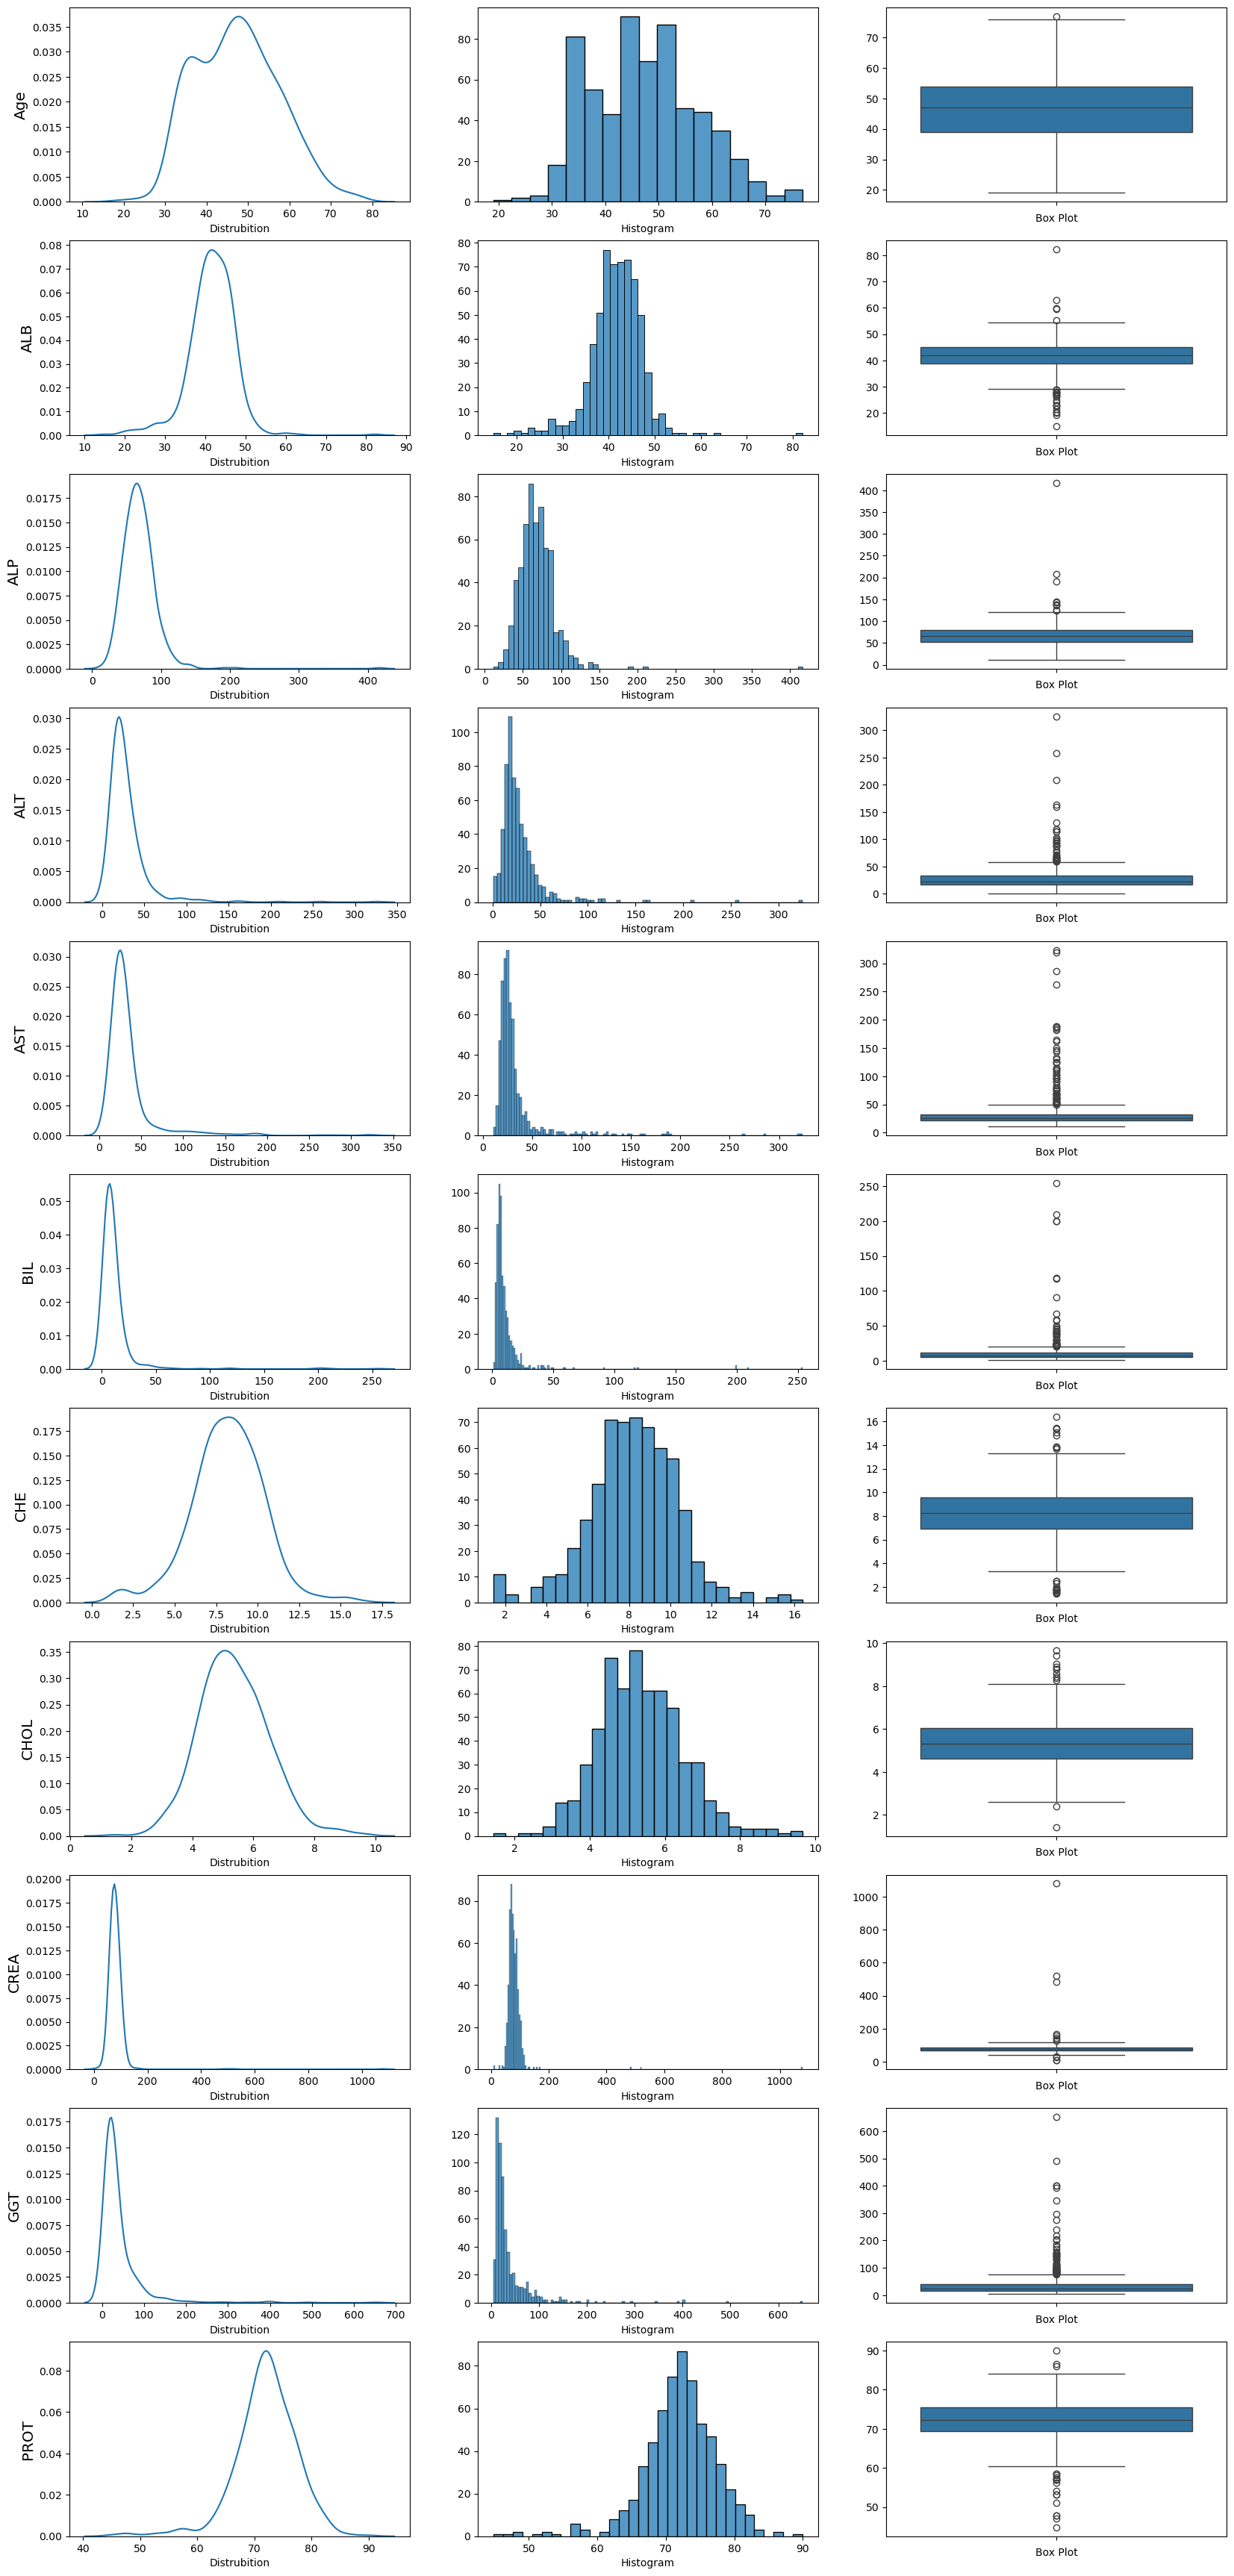

In [6]:
continuous_columns = [col for col in dataset.columns if col not in discrete_columns]

plot_continuous_columns(dataset, continuous_columns)
plt.show()

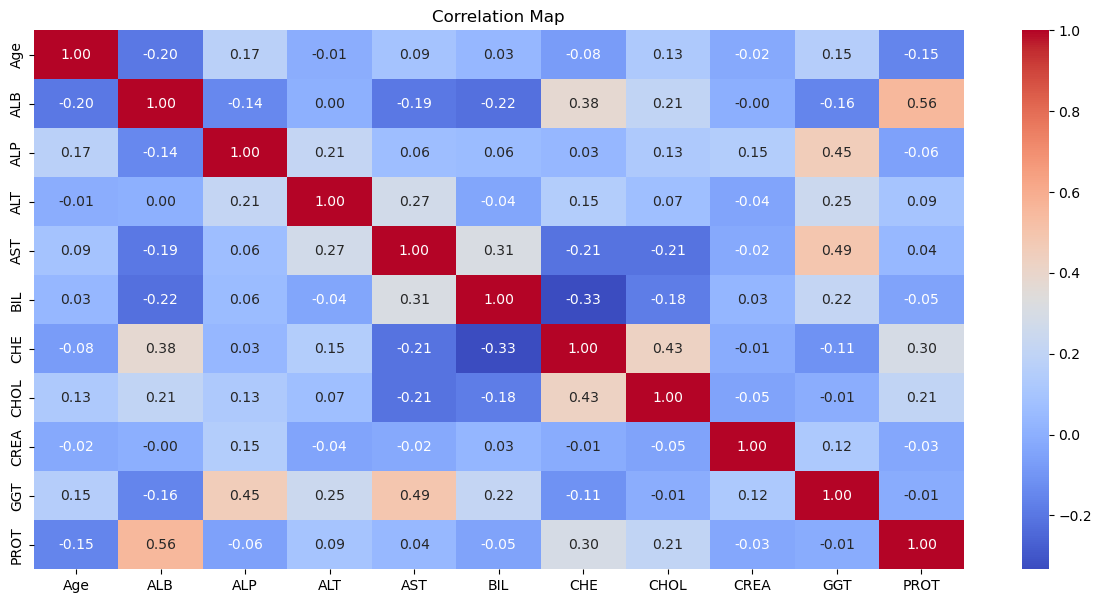

In [7]:
plot_corelation_matrix(dataset, continuous_columns)
plt.show()

# Detect Metadata

In [8]:
from src.evaluation.synthesizer_evaluation import SynthesizerEvaluation
from sdv.metadata.single_table import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(dataset)

# Check The Metadata

In [9]:
types = pd.DataFrame(
    data={
        'Dataset': ['categorical' if col in  discrete_columns else 'numerical' for col in dataset.columns],
        'metadata': [metadata.columns[key]['sdtype'] for key in metadata.columns]
    }   
)

types

,Dataset,metadata
0,categorical,categorical
1,numerical,numerical
2,categorical,categorical
3,numerical,numerical
4,numerical,numerical
5,numerical,numerical
6,numerical,numerical
7,numerical,numerical
8,numerical,numerical
9,numerical,numerical


# Evaluate Different HyperParameters Using Grid Search

In [10]:
synthesizerevaluation = SynthesizerEvaluation(
    param_grid = {
        'epochs': [100, 300, 500, 1000, 2000, 4000],
        # 'epochs': [300, 500, 1000],
        'lr': [2.5e-5, 5e-5, 1e-4, 2e-4, 4e-4, 8e-4]
        # 'lr': [4e-4]
    },
    save_synthesizers=True,
    dataset_name='hcvdata',
    folder_path=None,
    verbose=True
)
synthesizerevaluation.fit(dataset, metadata)

Fitting Hyperparameters: {'epochs': 100, 'generator_lr': 2.5e-05, 'discriminator_lr': 2.5e-05}


/home/tsmn/anaconda3/envs/gan12/lib/python3.12/site-packages/sdv/single_table/base.py:105: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Gen. (0.87) | Discrim. (-0.22): 100%|██████████| 100/100 [00:03<00:00, 30.99it/s]


Fitting Hyperparameters: {'epochs': 100, 'generator_lr': 5e-05, 'discriminator_lr': 5e-05}


Gen. (0.46) | Discrim. (-0.26): 100%|██████████| 100/100 [00:01<00:00, 50.17it/s]


Fitting Hyperparameters: {'epochs': 100, 'generator_lr': 0.0001, 'discriminator_lr': 0.0001}


Gen. (-0.47) | Discrim. (0.06): 100%|██████████| 100/100 [00:02<00:00, 49.31it/s]


Fitting Hyperparameters: {'epochs': 100, 'generator_lr': 0.0002, 'discriminator_lr': 0.0002}


Gen. (-0.37) | Discrim. (-0.04): 100%|██████████| 100/100 [00:02<00:00, 44.14it/s]


Fitting Hyperparameters: {'epochs': 100, 'generator_lr': 0.0004, 'discriminator_lr': 0.0004}


Gen. (0.51) | Discrim. (-1.05): 100%|██████████| 100/100 [00:01<00:00, 54.84it/s]


Fitting Hyperparameters: {'epochs': 100, 'generator_lr': 0.0008, 'discriminator_lr': 0.0008}


Gen. (-1.82) | Discrim. (0.07): 100%|██████████| 100/100 [00:02<00:00, 47.25it/s]


Fitting Hyperparameters: {'epochs': 300, 'generator_lr': 2.5e-05, 'discriminator_lr': 2.5e-05}


Gen. (-0.29) | Discrim. (-0.08): 100%|██████████| 300/300 [00:06<00:00, 48.09it/s]


Fitting Hyperparameters: {'epochs': 300, 'generator_lr': 5e-05, 'discriminator_lr': 5e-05}


Gen. (-0.22) | Discrim. (0.04): 100%|██████████| 300/300 [00:05<00:00, 51.59it/s] 


Fitting Hyperparameters: {'epochs': 300, 'generator_lr': 0.0001, 'discriminator_lr': 0.0001}


Gen. (-1.23) | Discrim. (-0.04): 100%|██████████| 300/300 [00:06<00:00, 46.32it/s]


Fitting Hyperparameters: {'epochs': 300, 'generator_lr': 0.0002, 'discriminator_lr': 0.0002}


Gen. (-1.43) | Discrim. (0.12): 100%|██████████| 300/300 [00:06<00:00, 46.12it/s] 


Fitting Hyperparameters: {'epochs': 300, 'generator_lr': 0.0004, 'discriminator_lr': 0.0004}


Gen. (-1.42) | Discrim. (0.06): 100%|██████████| 300/300 [00:06<00:00, 45.83it/s] 


Fitting Hyperparameters: {'epochs': 300, 'generator_lr': 0.0008, 'discriminator_lr': 0.0008}


Gen. (0.71) | Discrim. (0.23): 100%|██████████| 300/300 [00:06<00:00, 49.66it/s]  


Fitting Hyperparameters: {'epochs': 500, 'generator_lr': 2.5e-05, 'discriminator_lr': 2.5e-05}


Gen. (0.14) | Discrim. (-0.12): 100%|██████████| 500/500 [00:10<00:00, 48.29it/s] 


Fitting Hyperparameters: {'epochs': 500, 'generator_lr': 5e-05, 'discriminator_lr': 5e-05}


Gen. (-0.53) | Discrim. (-0.04): 100%|██████████| 500/500 [00:10<00:00, 49.25it/s]


Fitting Hyperparameters: {'epochs': 500, 'generator_lr': 0.0001, 'discriminator_lr': 0.0001}


Gen. (-1.57) | Discrim. (-0.10): 100%|██████████| 500/500 [00:10<00:00, 45.50it/s]


Fitting Hyperparameters: {'epochs': 500, 'generator_lr': 0.0002, 'discriminator_lr': 0.0002}


Gen. (-2.77) | Discrim. (0.22): 100%|██████████| 500/500 [00:10<00:00, 49.30it/s] 


Fitting Hyperparameters: {'epochs': 500, 'generator_lr': 0.0004, 'discriminator_lr': 0.0004}


Gen. (-1.66) | Discrim. (0.21): 100%|██████████| 500/500 [00:10<00:00, 47.01it/s] 


Fitting Hyperparameters: {'epochs': 500, 'generator_lr': 0.0008, 'discriminator_lr': 0.0008}


Gen. (0.56) | Discrim. (-0.35): 100%|██████████| 500/500 [00:10<00:00, 47.38it/s] 


Fitting Hyperparameters: {'epochs': 1000, 'generator_lr': 2.5e-05, 'discriminator_lr': 2.5e-05}


Gen. (-0.41) | Discrim. (0.13): 100%|██████████| 1000/1000 [00:20<00:00, 47.76it/s]


Fitting Hyperparameters: {'epochs': 1000, 'generator_lr': 5e-05, 'discriminator_lr': 5e-05}


Gen. (-2.15) | Discrim. (-0.03): 100%|██████████| 1000/1000 [00:20<00:00, 48.40it/s]


Fitting Hyperparameters: {'epochs': 1000, 'generator_lr': 0.0001, 'discriminator_lr': 0.0001}


Gen. (-2.45) | Discrim. (-0.06): 100%|██████████| 1000/1000 [00:20<00:00, 49.41it/s]


Fitting Hyperparameters: {'epochs': 1000, 'generator_lr': 0.0002, 'discriminator_lr': 0.0002}


Gen. (-2.25) | Discrim. (-0.24): 100%|██████████| 1000/1000 [00:21<00:00, 46.55it/s]


Fitting Hyperparameters: {'epochs': 1000, 'generator_lr': 0.0004, 'discriminator_lr': 0.0004}


Gen. (-2.13) | Discrim. (-0.02): 100%|██████████| 1000/1000 [00:23<00:00, 41.69it/s]


Fitting Hyperparameters: {'epochs': 1000, 'generator_lr': 0.0008, 'discriminator_lr': 0.0008}


Gen. (-1.36) | Discrim. (-0.34): 100%|██████████| 1000/1000 [00:23<00:00, 42.46it/s]


Fitting Hyperparameters: {'epochs': 2000, 'generator_lr': 2.5e-05, 'discriminator_lr': 2.5e-05}


Gen. (-2.14) | Discrim. (-0.03): 100%|██████████| 2000/2000 [00:48<00:00, 41.10it/s]


Fitting Hyperparameters: {'epochs': 2000, 'generator_lr': 5e-05, 'discriminator_lr': 5e-05}


Gen. (-2.11) | Discrim. (-0.04): 100%|██████████| 2000/2000 [00:49<00:00, 40.36it/s]


Fitting Hyperparameters: {'epochs': 2000, 'generator_lr': 0.0001, 'discriminator_lr': 0.0001}


Gen. (-2.42) | Discrim. (-0.12): 100%|██████████| 2000/2000 [00:48<00:00, 41.25it/s]


Fitting Hyperparameters: {'epochs': 2000, 'generator_lr': 0.0002, 'discriminator_lr': 0.0002}


Gen. (-2.83) | Discrim. (0.04): 100%|██████████| 2000/2000 [00:35<00:00, 56.12it/s] 


Fitting Hyperparameters: {'epochs': 2000, 'generator_lr': 0.0004, 'discriminator_lr': 0.0004}


Gen. (-3.32) | Discrim. (-0.02): 100%|██████████| 2000/2000 [00:35<00:00, 55.94it/s]


Fitting Hyperparameters: {'epochs': 2000, 'generator_lr': 0.0008, 'discriminator_lr': 0.0008}


Gen. (-3.57) | Discrim. (0.12): 100%|██████████| 2000/2000 [00:33<00:00, 59.41it/s] 


Fitting Hyperparameters: {'epochs': 4000, 'generator_lr': 2.5e-05, 'discriminator_lr': 2.5e-05}


Gen. (-2.42) | Discrim. (-0.09): 100%|██████████| 4000/4000 [01:10<00:00, 56.66it/s]


Fitting Hyperparameters: {'epochs': 4000, 'generator_lr': 5e-05, 'discriminator_lr': 5e-05}


Gen. (-1.89) | Discrim. (0.04): 100%|██████████| 4000/4000 [01:09<00:00, 57.18it/s] 


Fitting Hyperparameters: {'epochs': 4000, 'generator_lr': 0.0001, 'discriminator_lr': 0.0001}


Gen. (-2.28) | Discrim. (-0.04): 100%|██████████| 4000/4000 [01:10<00:00, 57.12it/s]


Fitting Hyperparameters: {'epochs': 4000, 'generator_lr': 0.0002, 'discriminator_lr': 0.0002}


Gen. (-2.18) | Discrim. (-0.13): 100%|██████████| 4000/4000 [01:09<00:00, 57.54it/s]


Fitting Hyperparameters: {'epochs': 4000, 'generator_lr': 0.0004, 'discriminator_lr': 0.0004}


Gen. (-3.47) | Discrim. (0.08): 100%|██████████| 4000/4000 [01:12<00:00, 54.80it/s] 


Fitting Hyperparameters: {'epochs': 4000, 'generator_lr': 0.0008, 'discriminator_lr': 0.0008}


Gen. (-2.38) | Discrim. (-0.21): 100%|██████████| 4000/4000 [01:10<00:00, 57.05it/s]


In [11]:
evals = synthesizerevaluation.get_evals()


In [12]:
evals

,generator_dim,discriminator_dim,generator_lr,generator_decay,discriminator_lr,discriminator_decay,batch_size,discriminator_steps,log_frequency,epochs,pac,KST,CJSD,WD,JSD,TVT,losses,paths
0,"[256, 256]","[256, 256]",0.000025,0.000001,0.000025,0.000001,500,1,True,100,10,0.617279,0.692347,0.106732,0.770983,0.694634,Generator Loss Discriminator Loss 0 ...,../models/hcvdata/CTGAN/14795f84474d0e771d5364...
1,"[256, 256]","[256, 256]",0.00005,0.000001,0.00005,0.000001,500,1,True,100,10,0.728758,0.763392,0.066771,0.83146,0.78439,Generator Loss Discriminator Loss 0 ...,../models/hcvdata/CTGAN/184d45bbb3b38ebf0fdb1d...
2,"[256, 256]","[256, 256]",0.0001,0.000001,0.0001,0.000001,500,1,True,100,10,0.785006,0.821221,0.031897,0.877535,0.850081,Generator Loss Discriminator Loss 0 ...,../models/hcvdata/CTGAN/1abc0f433f5d1ffa4ebe51...
3,"[256, 256]","[256, 256]",0.0002,0.000001,0.0002,0.000001,500,1,True,100,10,0.640221,0.716621,0.07688,0.880313,0.854472,Generator Loss Discriminator Loss 0 ...,../models/hcvdata/CTGAN/860bec82cbcdaadfa3c340...
4,"[256, 256]","[256, 256]",0.0004,0.000001,0.0004,0.000001,500,1,True,100,10,0.647859,0.690191,0.07549,0.904282,0.88748,Generator Loss Discriminator Loss 0 ...,../models/hcvdata/CTGAN/26f7ff3f38129923225308...
5,"[256, 256]","[256, 256]",0.0008,0.000001,0.0008,0.000001,500,1,True,100,10,0.701256,0.694457,0.077268,0.901284,0.883577,Generator Loss Discriminator Loss 0 ...,../models/hcvdata/CTGAN/a8d9d4f5dbc008e45376e2...
6,"[256, 256]","[256, 256]",0.000025,0.000001,0.000025,0.000001,500,1,True,300,10,0.729964,0.799626,0.044968,0.875679,0.847317,Generator Loss Discriminator Loss 0 ...,../models/hcvdata/CTGAN/dc7b2a876614a38bea2bd4...
7,"[256, 256]","[256, 256]",0.00005,0.000001,0.00005,0.000001,500,1,True,300,10,0.821207,0.84504,0.027186,0.895838,0.876098,Generator Loss Discriminator Loss 0 ...,../models/hcvdata/CTGAN/2897828b6d0844eaf06b0d...
8,"[256, 256]","[256, 256]",0.0001,0.000001,0.0001,0.000001,500,1,True,300,10,0.760142,0.79057,0.043128,0.89845,0.879675,Generator Loss Discriminator Loss 0 ...,../models/hcvdata/CTGAN/fedff430ea41eb6df2910a...
9,"[256, 256]","[256, 256]",0.0002,0.000001,0.0002,0.000001,500,1,True,300,10,0.654636,0.713658,0.073258,0.895425,0.875285,Generator Loss Discriminator Loss 0 ...,../models/hcvdata/CTGAN/fa72e5484785073d2cc6f9...


In [13]:
evals.groupby(['epochs', 'generator_lr'])[['KST', 'CJSD', 'WD', 'JSD', 'TVT']].mean()

KST      CJSD        WD       JSD       TVT
epochs generator_lr                                                  
100    0.000025      0.617279  0.692347  0.106732  0.770983  0.694634
       0.00005       0.728758  0.763392  0.066771   0.83146   0.78439
       0.0001        0.785006  0.821221  0.031897  0.877535  0.850081
       0.0002        0.640221  0.716621   0.07688  0.880313  0.854472
       0.0004        0.647859  0.690191   0.07549  0.904282   0.88748
       0.0008        0.701256  0.694457  0.077268  0.901284  0.883577
300    0.000025      0.729964  0.799626  0.044968  0.875679  0.847317
       0.00005       0.821207   0.84504  0.027186  0.895838  0.876098
       0.0001        0.760142   0.79057  0.043128   0.89845  0.879675
       0.0002        0.654636  0.713658  0.073258  0.895425  0.875285
       0.0004        0.557758  0.676318  0.085132  0.902633  0.885203
       0.0008        0.594187   0.62695  0.093427  0.886044  0.862602
500    0.000025      0.839008  0.848082  0.029681  0.881192  0.854959
       0.00005       0.804713  0.819477  0.042135  0.889221  0.866829
       0.0001        0.735709   0.78814  0.052768  0.896612  0.876911
       0.0002        0.672572  0.741378  0.083589  0.879813  0.853171
       0.0004        0.656266  0.747344  0.058341  0.890503  0.868943
       0.0008        0.657739  0.709697  0.065008  0.894645  0.874797
1000   0.000025      0.834191  0.834607  0.034212  0.895469  0.875447
       0.00005       0.799995  0.835135  0.029652  0.901191  0.883415
       0.0001          0.7725  0.792358  0.053418  0.884929  0.860488
       0.0002        0.709297   0.76234  0.058587  0.894277  0.873659
       0.0004        0.805275  0.826402  0.036061  0.863535  0.830244
       0.0008        0.826686  0.837327  0.028692  0.865258  0.832683
2000   0.000025      0.845955  0.837328  0.030812  0.906174  0.890407
       0.00005       0.782216  0.785427  0.054704  0.883027  0.857724
       0.0001        0.750207  0.760593  0.063803  0.890642  0.868455
       0.0002        0.789422  0.822008  0.039037  0.896386  0.876585
       0.0004        0.836558  0.833121  0.035122  0.897023  0.877724
       0.0008        0.857632  0.854502  0.018895  0.882395  0.856911
4000   0.000025      0.809625  0.807811  0.041392  0.892727  0.871382
       0.00005       0.800812  0.779773  0.047835  0.892403  0.870894
       0.0001        0.872622  0.867538  0.027892   0.89794  0.879024
       0.0002        0.875605  0.868147   0.02957  0.867645  0.836423
       0.0004        0.848031  0.855031  0.028992  0.865146  0.832846
       0.0008        0.847215  0.835056  0.027848  0.898131  0.879837

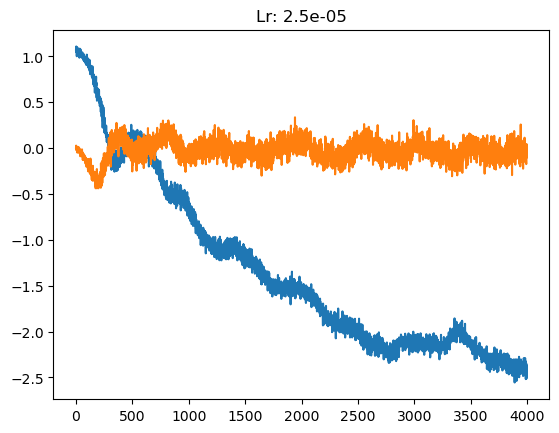

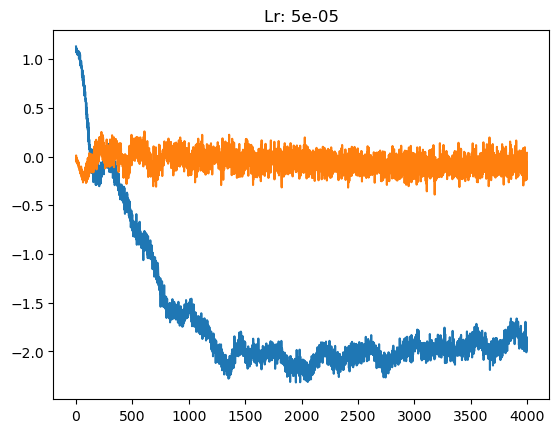

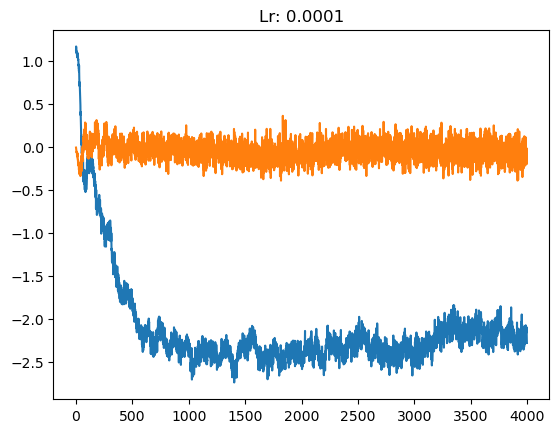

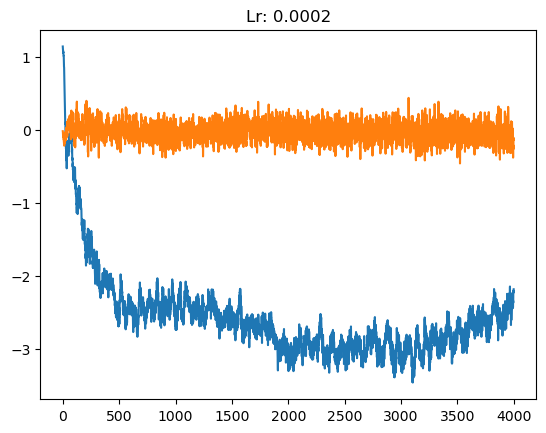

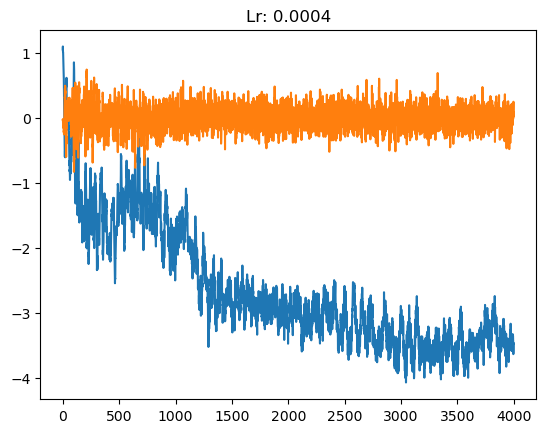

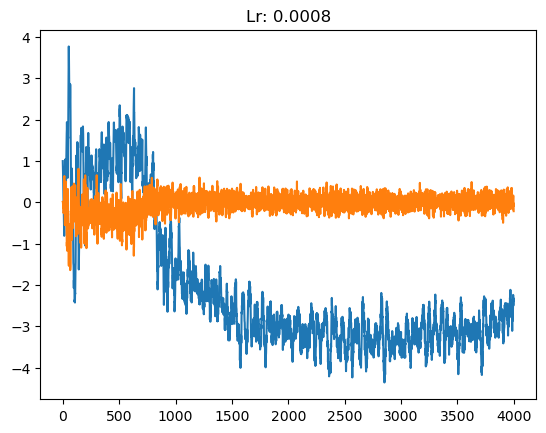

In [14]:
lr_values = evals.generator_lr.unique()

for lr in lr_values:
    for loss in evals[evals.generator_lr == lr]['losses']:
        if len(loss) == 4000:
            plt.title(f'Lr: {lr}')
            plt.plot(pd.DataFrame(loss))
            plt.show()
    